<a href="https://colab.research.google.com/github/JackBstn/NLP/blob/main/chronos_multivariate_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chronos adaptation to Multivariate Input: Preprocessing Multivariate Time Series

This notebook is designed to explore preprocessing techniques that transform multivariate time series data into univariate formats suitable for analysis with Chronos. It focuses on two primary preprocessing methods:
1. **Simple Transformation Methods**: Aggregating multiple variables into a single representative feature (Weighted Sum, Arithmetic Mean, Volume Weighted Average Price, PCA).
2. **Machine Learning-Based Methods**: Employ machine learning models to capture the underlying relationships among variables (Linear Regression, Random Forest, Support Vector Regression).

In this notebook, we apply these techniques to Apple stock market data, where the goal is to predict the Close price. The dataset includes multiple financial indicators (Open, High, Low, Volume, Close), and our preprocessing steps will transform these multivariate inputs into a univariate format, enabling the application of Chronos for forecasting. For comparison, we also evaluate Chronos using only the historical values of the Close price as input, without any transformation from multivariate data. This allows us to determine whether incorporating additional variables enhances forecasting performance.

The evaluation includes calculating various metrics such as MSE, RMSE, MAPE, and MASE,
and visualizing the forecast results to compare the performance of the fine-tuned model against the zero-shot model.

#### Install Dependencies

In [1]:
!pip install torch transformers chronos yfinance pandas matplotlib
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.7 MB/s eta 0:00:00
  Created wheel for chronos: filename=chronos-0.3-py3-none-any.whl size=7374 sha256=e0fdf7fecc6400da04e9e61819d20173f80ab7838aac47225fc3a3084e727fda
  Stored in di

In [2]:
import pandas as pd
import yfinance as yf
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gmean
from sklearn.metrics import mean_squared_error

### Utils

In [3]:
# Function to compute MASE
def mase(y_true, y_pred, y_train):
    naive_forecast = np.abs(np.diff(y_train)).mean()  # Naive benchmark
    return np.mean(np.abs(y_true - y_pred)) / naive_forecast

# Function to compute evaluation metrics
def compute_metrics(y_true, y_pred, y_train):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mase_score = mase(y_true, y_pred, y_train)
    return { "MSE": mse, "RMSE": rmse, "MAPE": mape, "MASE": mase_score }

# Function to compute the relative score
def agg_relative_score(model_df: pd.DataFrame, baseline_df: pd.DataFrame):
    relative_score = model_df / baseline_df  # Ratio between model and baseline
    return relative_score.agg(gmean)  # Geometric mean of improvements

## Pre-processing (from multivariate to univariate) using simple methods

Download data and Chronos model:

In [4]:
# Set seed for reproducibility
seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Download data from Yahoo Finance (AAPL)
symbol = "AAPL"
data = yf.download(symbol, start="2023-09-01", end="2023-12-31", progress=False)
data_to_predict = yf.download(symbol, start="2024-01-01", end="2024-02-15", progress=False)
all_close_values = np.concatenate([data['Close'].values, data_to_predict['Close'].values])

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

# Chronos model
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda",  # Usa "cpu" se non hai una GPU disponibile
    torch_dtype=torch.bfloat16,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

Define the preprocessing methods:

In [7]:
# Function to calculate PCA
def calculate_pca(data, scaler):
    pca = PCA(n_components=1)
    aapl_pca = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_[0]
    print(f"Explained Variance Ratio of the first component: {explained_variance}")
    return aapl_pca.flatten() * np.sqrt(pca.explained_variance_[0]) + scaler.mean_[3]  # Shift by Close mean

# Solution 1: Weighted Mean (Open, High, Low, Close)
weights = {'Open': 0.2, 'High': 0.3, 'Low': 0.3, 'Close': 0.2}
aapl_combined = (data['Open'] * weights['Open'] +
                 data['High'] * weights['High'] +
                 data['Low'] * weights['Low'] +
                 data['Close'] * weights['Close'])

# Solution 2: Arithmetic Mean (Open, High, Low, Close)
aapl_mean = data[['Open', 'High', 'Low', 'Close']].mean(axis=1)

# Solution 3: Volume Weighted Average Price (VWAP)
aapl_vwap = (data['Volume'] * (data['High'] + data['Low']) / 2).cumsum() / data['Volume'].cumsum()

# Solution 4: Principal Component Analysis (PCA)
aapl_pca_rescaled = calculate_pca(scaled_data, scaler)
aapl_pca_series = pd.Series(aapl_pca_rescaled, index=data.index)

Explained Variance Ratio of the first component: 0.8085689991243603


Chronos prediction using:
1. Only Close prices
2. Univariate input obtained from preprocessing methods

<ipython-input-3-3a5f6b870b14>:3: RuntimeWarning: Mean of empty slice.
  naive_forecast = np.abs(np.diff(y_train)).mean()  # Naive benchmark
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3a5f6b870b14>:3: RuntimeWarning: Mean of empty slice.
  naive_forecast = np.abs(np.diff(y_train)).mean()  # Naive benchmark
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Weighted Mean
Variance: [ 279.3557   346.70038  732.84375 1155.2211  1579.0247  1899.4154
 2773.7173  3184.5918  3565.2544  4089.063   4413.07    4727.9097
 5118.702   5417.0947  5580.5737  5803.2515  5974.1475  6224.508
 5865.995   6472.54    6748.9673  6453.6597  6152.5615  5623.505
 5815.5576  5680.4883  5586.1636  5252.8447  4892.069   4695.355  ]


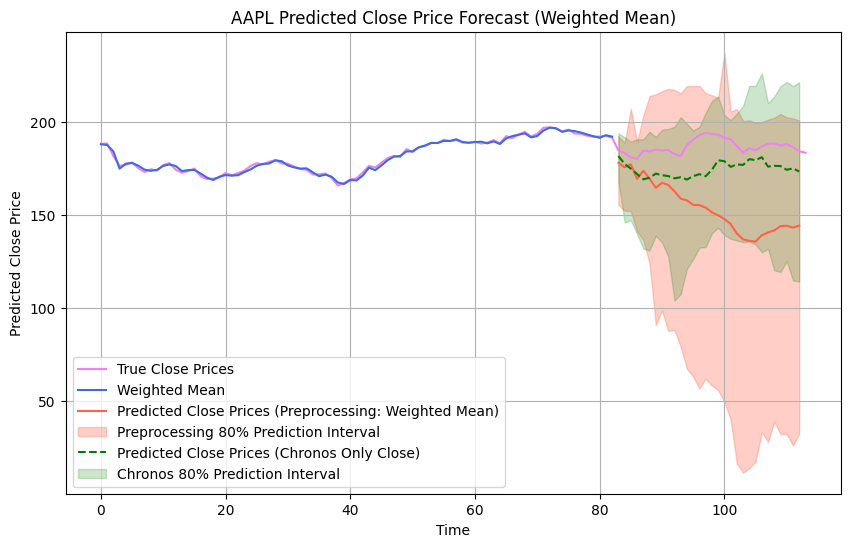

Arithmetic Mean
Variance: [  2.6426268   4.518173    8.956519   15.181714   19.704287   29.06867
  32.52712    42.210743   45.203617   61.34746    68.17562    74.04173
  84.47024    94.04747    93.72821   100.43224   101.784546   96.70775
 103.7355    118.84619   107.28259   115.96864   138.53271   150.22049
 163.4291    195.6724    190.52904   196.91383   211.9403    217.16792  ]


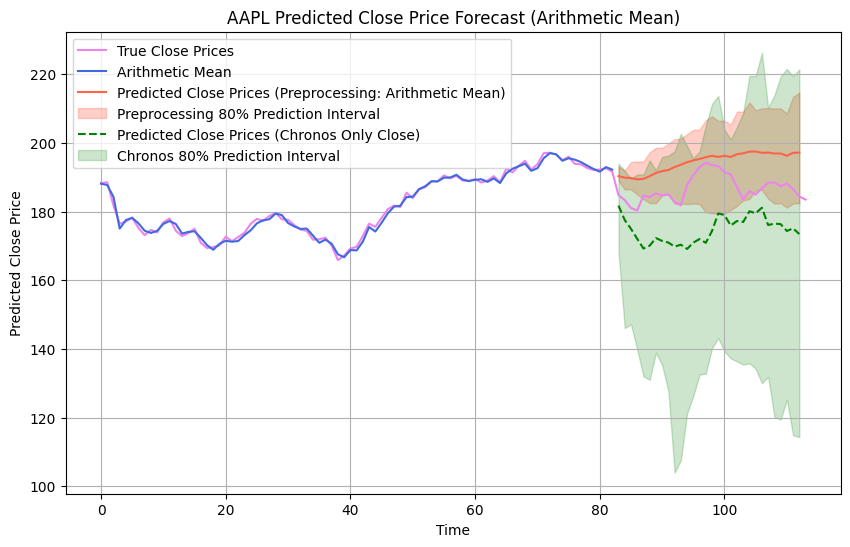

<ipython-input-3-3a5f6b870b14>:3: RuntimeWarning: Mean of empty slice.
  naive_forecast = np.abs(np.diff(y_train)).mean()  # Naive benchmark
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


VWAP
Variance: [1896.6477 2234.399  2599.234  2591.6406 2315.1475 2202.085  2134.1255
 2252.124  1880.3601 1830.9332 1735.3346 1917.2634 2068.9375 3014.1465
 3399.0032 4115.234  4270.539  4636.129  4952.6514 5270.6597 5448.945
 5506.1064 5941.783  6040.2666 6132.1665 6221.0283 6074.2695 6216.5483
 5889.2993 5982.581 ]


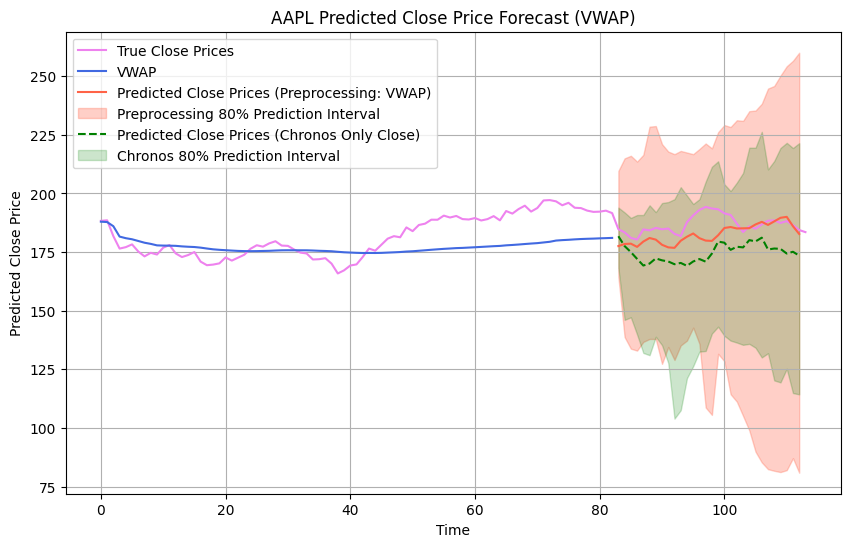

PCA
Variance: [ 0.35518673  2.9125314   3.4453113   3.1034439   3.4630713   6.4644113
  7.6853676   6.6597643   7.352379    7.5299735   7.1215034   6.855104
  7.543289    5.1502075   5.4121575   6.2335367   8.96405    10.207206
 10.939781   11.166217   12.857803   12.942152   14.012154   15.432898
 15.8902025  16.853657   18.16341    19.268927   16.067783   16.232067  ]


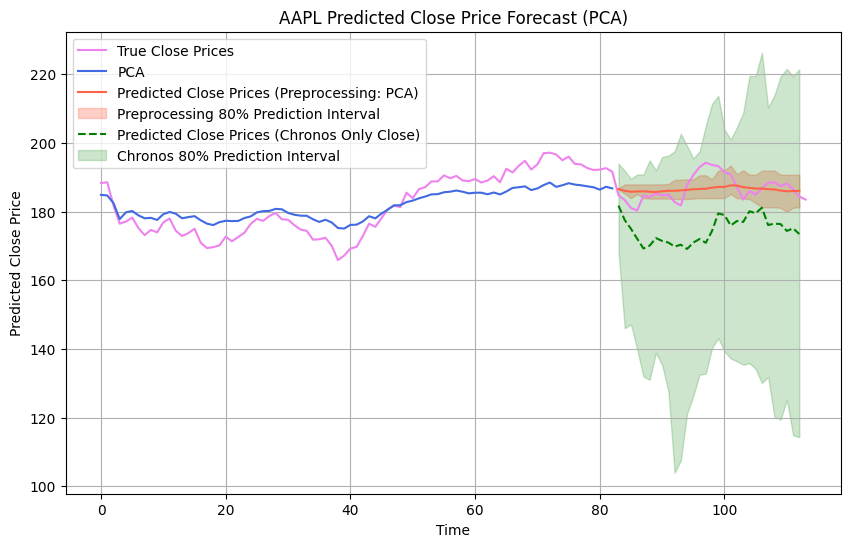

PERFORMANCE METRICS:
                            MSE       RMSE       MAPE      MASE
Chronos Only Close   172.388498  13.129680   6.482399       NaN
Weighted Mean       1287.995346  35.888652  17.392139       NaN
Arithmetic Mean       68.549281   8.279449   4.274226  5.705832
VWAP                  38.572769   6.210698   2.995874       NaN
PCA                   12.035166   3.469174   1.625428  4.348964
-------------------------------------------------
SCALING PERFORMANCE (Preprocessing vs Chronos Only Close):
MSE     0.464146
RMSE    0.681282
MAPE    0.672883
MASE         NaN
dtype: float64


In [29]:
# Dictionary to store metrics
results = {}

# Chronos prediction using only Close prices
forecast_close = pipeline.predict(
    context=torch.tensor(data['Close'].values), prediction_length=30
)

# Extract forecast statistics
forecast_index_close = range(len(data['Close']), len(data['Close']) + 30)
low_close, median_close, high_close = np.quantile(forecast_close[0].numpy(), [0.1, 0.5, 0.9], axis=0)
mean_forecast_close = np.mean(forecast_close[0].numpy(), axis=0)

# Compute metrics for Chronos (Close-only)
actual_values = data_to_predict['Close'].values[:30] # True values for comparison
results["Chronos Only Close"] = compute_metrics(actual_values, mean_forecast_close, data['Close'])

# Chronos prediction using preprocessing methods
methods = {
    "Weighted Mean": aapl_combined,
    "Arithmetic Mean": aapl_mean,
    "VWAP": aapl_vwap,
    "PCA": aapl_pca_series
}

for title, close_prices in methods.items():
    # Step 1: Chronos prediction
    forecast = pipeline.predict(
        context=torch.tensor(close_prices.values), prediction_length=30
    )

    forecast_index = range(len(close_prices), len(close_prices) + 30)
    low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
    mean_forecast = np.mean(forecast[0].numpy(), axis=0)
    variance_forecast = np.var(forecast[0].numpy(), axis=0)

    # Step 2: Compute metrics
    results[title] = compute_metrics(actual_values, mean_forecast, close_prices.values)

    # Step 3: Visualization
    print(f"{title}")
    print(f'Variance: {variance_forecast}')

    plt.figure(figsize=(10, 6))
    plt.plot(all_close_values, color="violet", label="True Close Prices")  # True Close Prices
    plt.plot(close_prices.values, color="royalblue", label=f"{title}")  # Close Prices using preprocessing methods

    # Predicted Close Prices using preprocessing methods
    plt.plot(forecast_index, mean_forecast, color="tomato", label=f"Predicted Close Prices (Preprocessing: {title})")
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="Preprocessing 80% Prediction Interval")

    # Add Chronos-only Close prediction
    plt.plot(forecast_index_close, mean_forecast_close, color="green", linestyle="dashed",
            label="Predicted Close Prices (Chronos Only Close)")
    plt.fill_between(forecast_index_close, low_close, high_close, color="green", alpha=0.2, label="Chronos 80% Prediction Interval")

    plt.title(f"{symbol} Predicted Close Price Forecast ({title})")
    plt.xlabel("Time")
    plt.ylabel("Predicted Close Price")
    plt.legend()
    plt.grid()
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()


# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("PERFORMANCE METRICS:")
print(results_df)

# Compute relative performance
relative_scores = agg_relative_score(results_df.iloc[1:], results_df.iloc[0])  # Exclude Chronos Only Close as baseline
print("-------------------------------------------------")
print("SCALING PERFORMANCE (Preprocessing vs Chronos Only Close):")
print(relative_scores)

## Pre-processing (from multivariate to univariate) using ML methods

Linear Regression Variance: [ 386.1115   534.43835  623.6177   802.11584  950.67303  823.1825
  975.3084  1035.5541  1170.748   1172.6619  1648.1829  1966.2969
 2206.0579  2641.3203  2892.7847  3348.7163  3301.843   4351.4233
 4560.562   4169.4956  3856.2026  4578.9805  5575.4146  5626.4546
 5332.997   4512.399   3488.9468  2682.5715  2256.974   2212.9072 ]


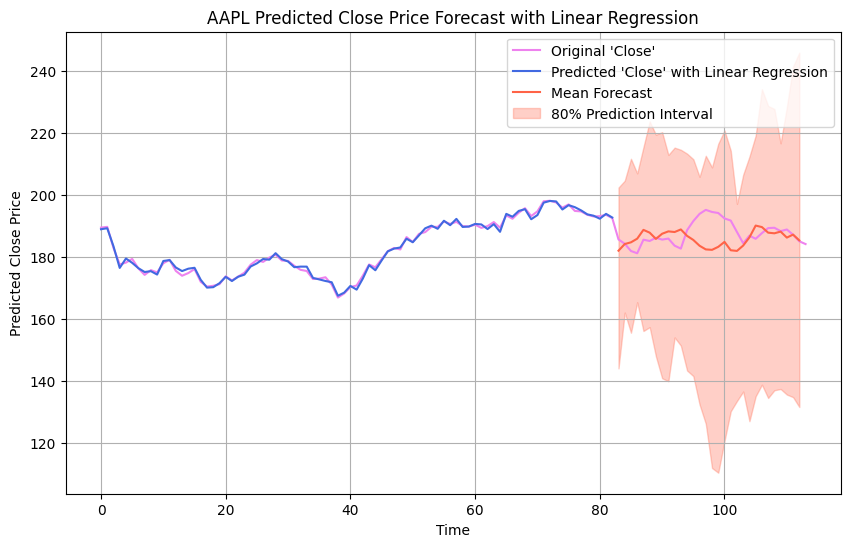

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Variance: [  1.3291757   2.132962    4.131199    9.1425     13.700274   16.214912
  16.250835   15.896088   26.76289    32.797997   40.61128    60.87205
  87.5226    101.35306   121.76196   115.75828   125.17019   147.21368
 139.61133   123.95329   118.63218   105.520164  101.50124   100.33378
 113.1584    116.54862   128.94662   151.68613   148.62814   128.33154  ]


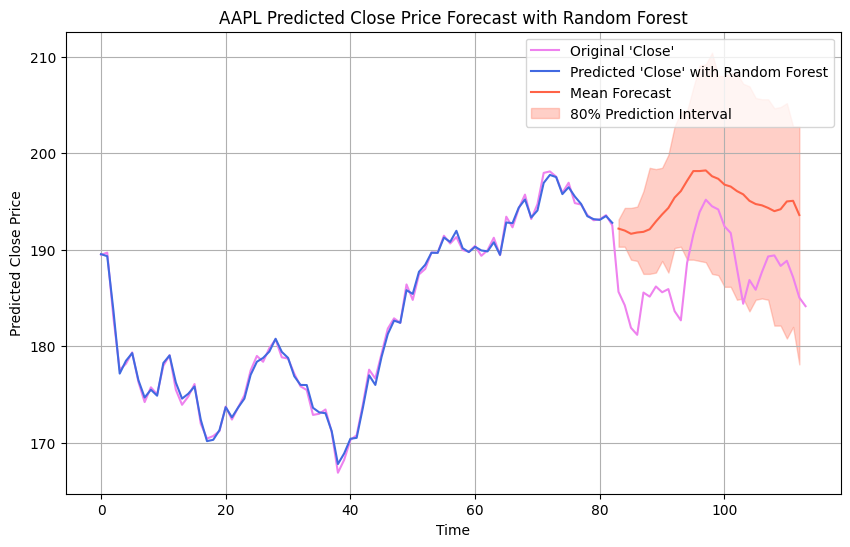

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Support Vector Regression Variance: [  1.6156919   3.1371226   6.727488    8.329688    7.5577683   6.9070005
  13.086939   18.539799   25.204416   30.24441    36.671173   40.117928
  47.48265    50.4627     49.955563   41.45084    38.66833    35.414562
  41.827847   41.307228   52.289257   70.38928    71.85686    83.853226
  86.09721    99.02255    96.47337    96.419525  105.24733   120.362816 ]


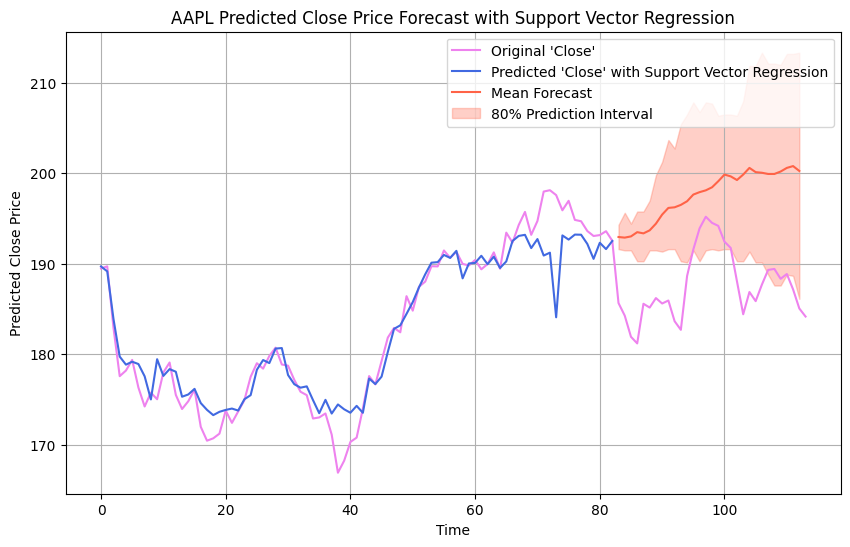

In [ ]:
import pandas as pd
import yfinance as yf
import torch
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Imposta il seed per riproducibilità
seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Scarica i dati da Yahoo Finance
symbol = "AAPL"
data = yf.download(symbol, start="2023-09-01", end="2023-12-31", progress=False)
data_to_predict = yf.download(symbol, start="2024-01-01", end="2024-02-15", progress=False)
close_to_predict = data_to_predict['Close']

# Preprocessamento dei dati
scaler = StandardScaler()
X = data[['Open', 'High', 'Low', 'Volume']].values
y = data['Close'].values
X_scaled = scaler.fit_transform(X)

# Modelli di regressione avanzata
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=seed),
    "Support Vector Regression": SVR(kernel='rbf')
}

# Modello Chronos per il forecasting
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda",  # Usa "cpu" se non hai una GPU disponibile
    torch_dtype=torch.bfloat16,
)

# Visualizza e confronta i risultati
all_close_values = np.concatenate([data['Close'].values, data_to_predict['Close'].values])
forecast_index = range(len(data), len(data) + 30)

for model_name, model in models.items():
    # Step 1: Fit del modello
    model.fit(X_scaled, y)

    # Previsione dei valori di Close
    predicted_close = model.predict(X_scaled)

    # Step 2: Forecasting con Chronos
    forecast = pipeline.predict(
        context=torch.tensor(predicted_close), prediction_length=30
    )

    # Step 3: Visualizzazione dei risultati
    low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
    mean_forecast = np.mean(forecast[0].numpy(), axis=0)
    variance_forecast = np.var(forecast[0].numpy(), axis=0)

    print(f"{model_name} Variance: {variance_forecast}")

    # Plotting the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(all_close_values, color="violet", label="Original 'Close'")
    plt.plot(predicted_close, color="royalblue", label=f"Predicted 'Close' with {model_name}")
    plt.plot(forecast_index, mean_forecast, color="tomato", label="Mean Forecast")
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")
    plt.title(f"{symbol} Predicted Close Price Forecast with {model_name}")
    plt.xlabel("Time")
    plt.ylabel("Predicted Close Price")
    plt.legend()
    plt.grid()
    plt.show()
